# CODE FOR FORECASTS TO SUBMITS

In [22]:
import os 
from __future__ import division
import numpy as np
import pandas as pd
import matplotlib 
import sklearn as sk
from sklearn import cross_validation
from sklearn.decomposition import PCA, KernelPCA
from matplotlib import pyplot as plt
from sklearn import *
from funk_py import *
%matplotlib inline
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA, KernelPCA


In [5]:
print os.listdir(os.getcwd())    
os.chdir("C:\\")
os.listdir(r"C:\cygwin64\home\MDjerrab\AppGenomique\data")
os.chdir(r"C:\cygwin64\home\MDjerrab\AppGenomique\data")

['.RData', '.Rhistory', 'Challenge_data_dictionary v2.xlsx', 'CoreTable_training.csv', 'DATA_CLEAN.csv', 'data_train_test_30-04-2015', 'dico_table.csv', 'LabValue_training.csv', 'leaderboard', 'LesionMeasure_training.csv', 'MedHistory_training.csv', 'PriorMed_training.csv', 'VitalSign_training.csv']


In [93]:
## Fichier CLEAN
data = pd.read_csv("DATA_CLEAN.csv",sep=";")
## drop ID RPT
data = data.drop("RPT",axis=1)
col_train = data.columns
data_test = pd.read_csv("leaderboard/DATA_CLEAN_PREDICT.csv",sep=";")
col_test = data_test.columns
data = data.drop('Unnamed: 0', 1)
data_test = data_test.drop('Unnamed: 0', 1)
## Fichier DICO
dico = pd.read_csv('dico_table.csv',sep=";")
dico = dico.loc[dico.Table == "CoreTable",:]

In [94]:
print data_test.shape
print data.shape

(157, 97)
(1600, 111)


###DATA PREPARATION

In [95]:
## Séparation en char et num
data_char,data_num = funk_data_cat_char_from_num(data)
data_char_test,data_num_test = funk_data_cat_char_from_num(data_test)

## Target 1 : DEATH
trgt1 = data_num.pop('DEATH')
trgt1 = trgt1.to_frame()
## Target 2 : LKADT_P
trgt2 = data_num.pop('LKADT_P')
trgt2 = trgt2.to_frame()

STUDYID
ENDTRS_C
AGEGRP
AGEGRP2
RACE_C
REGION_C
RPT
AGEGRP
AGEGRP2
RACE_C
HGTBLCAT
WGTBLCAT
REGION_C


### FEATURE EXTRACTION

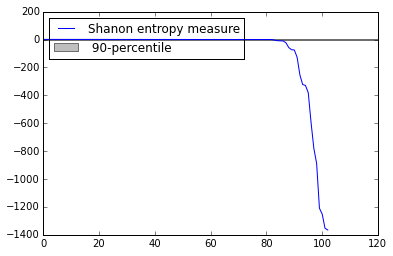

92


In [96]:
def funk_enthropy(test):
    return(-sum([x*np.log(x) for x in test if x!=0]))
test = data_num.copy()
test["DEATH"] =trgt1.DEATH
res = pd.DataFrame(test.columns[0:(len(test.columns)-1)],columns=["DEATH"])
res["shannon"]=0
test_1 = (1/len(test))*test.groupby("DEATH").sum()
ll=[]
for esc in range(len(test_1.T)):
    ll.append(funk_enthropy(test_1.iloc[:,esc]))
res.shannon = ll 

test = res.sort(['shannon'],ascending=[0])
val = np.percentile(test.iloc[:,1],90)

plt.figure()
plt.plot(test.iloc[:,1], label ="Shanon entropy measure")
plt.axhspan(0, val, xmin=0, xmax=16000 ,facecolor='0.5', alpha=0.5,label =" 90-percentile ")
plt.legend(loc='upper left')
plt.savefig(r'C:\Users\MDjerrab\Desktop\Altegrad\Altegrad_project\Shanon_reduction.png', format='png', dpi=1000)
plt.show()

## Feature reduction
name_feat_reduce = (test.loc[test.iloc[:,1]<val,'DEATH']).tolist()
print len(np.unique(name_feat_reduce))

### PREDICTION 1A : TOTAL PROBA OF DEATH

##### riskGlobal

In [131]:
data_num = data_num.loc[:,set(name_feat_reduce)&set(data_num_test.columns)]
clf =ensemble.RandomForestClassifier(random_state=1, n_estimators=100)
clf.fit(data_num, trgt1.iloc[:,0])
total_proba_death = clf.predict_proba(data_num_test.loc[:,set(name_feat_reduce)&set(data_num_test.columns)])

##### risk 12, 18, 24

In [98]:
trgt2["12mois"] =0
trgt2["18mois"] =0
trgt2["24mois"] =0
trgt2.loc[(trgt2.LKADT_P< 361),"12mois"] = 1
trgt2.loc[(trgt2.LKADT_P> 360)&(trgt2.LKADT_P< 541),"18mois"] = 1
trgt2.loc[(trgt2.LKADT_P> 540)&(trgt2.LKADT_P< 720),"24mois"] = 1
trgt1["riskScoreGlobal"] =0
trgt1["riskScore12"] =0
trgt1["riskScore18"] =0
trgt1["riskScore24"] =0
target = pd.concat([trgt2,trgt1],axis=1)
target.riskScoreGlobal = target.DEATH
target.loc[(target.DEATH == 1)&(target.loc[:,"12mois"]==1),"riskScore12"] = 1
target.loc[(target.DEATH == 1)&(target.loc[:,"18mois"]==1),"riskScore18"] = 1
target.loc[(target.DEATH == 1)&(target.loc[:,"24mois"]==1),"riskScore24"] = 1
target.loc[(target.loc[:,"12mois"]==1),"riskScore18"] = 1
target.loc[((target.loc[:,"18mois"]==1) | (target.loc[:,"12mois"]==1)),
           "riskScore24"] = 1

In [132]:
clf =ensemble.RandomForestClassifier(random_state=1, n_estimators=100)
clf.fit(data_num, target.iloc[:,6])
total_proba_death_12 = clf.predict_proba(data_num_test.loc[:,set(name_feat_reduce)&set(data_num_test.columns)])
clf.fit(data_num, target.iloc[:,7])
total_proba_death_18 = clf.predict_proba(data_num_test.loc[:,set(name_feat_reduce)&set(data_num_test.columns)])
clf.fit(data_num, target.iloc[:,8])
total_proba_death_24 = clf.predict_proba(data_num_test.loc[:,set(name_feat_reduce)&set(data_num_test.columns)])

### PREDICTION 1B : DURATION BEFORE DEATH

In [137]:
clf =RandomForestRegressor(random_state=1, n_estimators=100)
clf.fit(data_num, trgt2.iloc[:,0])
total_proba_duration = clf.predict(data_num_test.loc[:,set(name_feat_reduce)&set(data_num_test.columns)])

### SAVING FILES TO SUBMIT

##### 1A

In [152]:
subject1 = pd.DataFrame([data_test.RPT,total_proba_death[:,1],total_proba_death_12[:,1],
                      total_proba_death_18[:,1],total_proba_death_24[:,1]
                        ]).T
subject1.columns= ["RPT","riskScoreGlobal", "riskScore12", "riskScore18", 
                   "riskScore24"]
subject1.to_csv("..\subject1A_probas.csv",index=False)

##### 1B

In [153]:
subject2 = pd.DataFrame([data_test.RPT,total_proba_duration]).T
subject2.columns=["RPT","TIMETOEVENT"]
subject2.to_csv("..\subject1B_durations.csv",index=False)